# Gender analysis

This analysis is about to find out what are the most important aspects that characterize female art historians around the world. The analysis focus its attention on geographical characterisics to find out if there are differences among female and male art historians.

The data are taken from Wikidata dataset only, an open knowledge base that provides extensive information about the entities it contains, including gender information.

It  would be used SPARQLWrapper (an extended version of RDFlib), because on the one hand it allows to query a remote SPARQL endpoint (in this case the Wikidata one) and to get up-to-date result data in JSON format. On the other hand, it does not require us to separate the code for collecting the data from the code for manipulating results.

To do so, we get the URL of the API of the SPARQL endpoint, we prepare the SPARQL query regarding the worldwide number of male and female art historians, we then create the wrapper around the SPARQL API via SPARQLWrapper library, send the query and get the JSON results.

## Birthplaces

The analysis starts  extracting the birth places where the majority of the female art historians were born

In [32]:
from SPARQLWrapper import SPARQLWrapper, JSON
import ssl
import pprint as pp
import pandas as pd
import seaborn as sns

ssl._create_default_https_context = ssl._create_unverified_context

wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

sex_code = {"woman": "Q6581072",
            "men": "Q6581097"}



'Q6581072'

In [30]:
def sample_for_country(result, sex, subject):
    """
    * result: result of the query
    * sex: "man" or "woman" -> select the field "totman" or "totwoman"
    * subject: label of interest (example: placeofbirthLabel/educatedatLabel)
    """
    country_info = {}
    for person in result:
        city = person[subject]["value"]

        country = person["countryLabel"]["value"]
        n_birth = person[f"tot{sex}"]["value"]

        if country not in country_info:
            country_info[country] = []
        country_info[country].append((city, n_birth))

    
    tot_pp_per_country = {}
    for country in country_info:
        total_birth_per_country = sum([int(n) for _,n in country_info[country]])
        tot_pp_per_country[country] = total_birth_per_country
        
    return tot_pp_per_country




def get_top_sample_by_women(all_countries, women_sample, men_sample, top=10):
    total = []
    for country in all_countries:

        tot_w = 0
        tot_m = 0 

        if country in women_sample: 
            tot_w = women_sample[country]

        if country in men_sample: 
            tot_m = men_sample[country]

        total.append((country, tot_w, tot_m))

    top_on_women = [(w,m,c) for c,w,m in total]
    top_on_women.sort(reverse=True)
    top_on_women = top_on_women[:top]
    top_on_women = {c:{"women":w, "men":m} for w,m,c in top_on_women}
    return top_on_women


def get_women_man_differences(womenResults, manResults, label):
    """
    Given a result of two sparql querys (for woman and for men), 
    retrieve the differences by sex according to a specific label
    """
    women_data = sample_for_country(womenResults["results"]["bindings"], 
                                   sex="women", 
                                   subject=label)

    men_data = sample_for_country(manResults["results"]["bindings"], 
                                 sex="men", 
                                 subject=label)

    countries_of_data = set(women_data.keys()).union(set(men_data.keys()))
    print("women:\t", len(women_data), "\nmen:\t", len(men_data), "\nunion:\t", len(countries_of_data))

    data_dict = get_top_sample_by_women(countries_of_edu, women_edu, men_edu)
    df = pd.DataFrame.from_dict(data_dict, orient="index").plot.bar()
    return data_dict


In [33]:
fembirthplace_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT ?placeofbirth ?placeofbirthLabel ?countryLabel (COUNT(?person) AS ?totwomen)
WHERE
{
       ?person wdt:P31 wd:Q5 ;
            wdt:P21 wd:Q6581072 ;
            wdt:P106/wdt:P279* wd:Q1792450; 
            wdt:P19 ?placeofbirth.
           ?placeofbirth wdt:P17 ?country.
        ?country wdt:P297 ?countryCode.
       
       SERVICE wikibase:label {bd:serviceParam wikibase:language "en" }
}
GROUP BY ?placeofbirth ?placeofbirthLabel ?countryLabel
ORDER BY DESC(?totwomen)
"""
sparql_wd = SPARQLWrapper(wikidata_endpoint, agent='Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:47.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36')
sparql_wd.setQuery(fembirthplace_query)
sparql_wd.setReturnFormat(JSON)
womenbirthplacesResults = sparql_wd.query().convert()



menbirthplace_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT ?placeofbirth ?placeofbirthLabel ?countryLabel (COUNT(?person) AS ?totmen)
WHERE
{
       ?person wdt:P31 wd:Q5 ;
            wdt:P21 wd:Q6581097 ;
            wdt:P106/wdt:P279* wd:Q1792450; 
            wdt:P19 ?placeofbirth.
           ?placeofbirth wdt:P17 ?country.
       
       SERVICE wikibase:label {bd:serviceParam wikibase:language "en" }
}
GROUP BY ?placeofbirth ?placeofbirthLabel ?countryLabel
ORDER BY DESC(?totmen)
"""
sparql_wd = SPARQLWrapper(wikidata_endpoint, agent='Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:47.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36')
sparql_wd.setQuery(menbirthplace_query)
sparql_wd.setReturnFormat(JSON)
menbirthplacesResults = sparql_wd.query().convert()

women:	 82 
men:	 139 
union:	 147


{'United States of America': {'women': 487, 'men': 684},
 'France': {'women': 143, 'men': 446},
 'Germany': {'women': 125, 'men': 519},
 'Spain': {'women': 123, 'men': 147},
 'United Kingdom': {'women': 108, 'men': 440},
 'Soviet Union': {'women': 105, 'men': 216},
 'Poland': {'women': 90, 'men': 196},
 'Russia': {'women': 66, 'men': 95},
 'Canada': {'women': 49, 'men': 57},
 'Italy': {'women': 42, 'men': 135}}

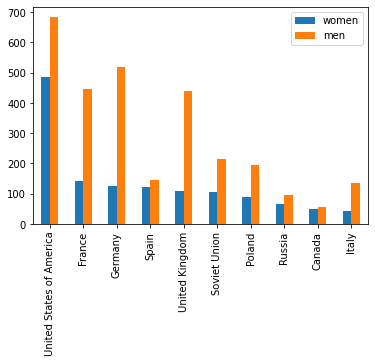

In [34]:
get_women_man_differences(womenResults = womenbirthplacesResults, 
                          manResults = menbirthplacesResults, 
                          label = "placeofbirthLabel")

In [15]:
for result in fembirthplacesResults["results"]["bindings"]:
    birthplaces = result["placeofbirthLabel"]["value"]
    totaln = result["totwomen"]["value"]
    country = result["countryLabel"]["value"]
    if result["totwomen"]["value"] == str(1):
        print("There is "+ totaln +" " + " female art historian born in " + birthplaces + "  (" + country+ ")")
    else:
        print("There are "+ totaln + " " + " female art historians born in " + birthplaces + "  (" + country+ ")")

There are 141  female art historians born in Prague  (Czech Republic)
There are 61  female art historians born in Vienna  (Austria)
There are 52  female art historians born in Berlin  (Germany)
There are 42  female art historians born in Brno  (Czech Republic)
There are 41  female art historians born in Budapest  (Hungary)
There are 39  female art historians born in Moscow  (Russia)
There are 29  female art historians born in Barcelona  (Spain)
There are 27  female art historians born in Rome  (Italy)
There are 27  female art historians born in Warsaw  (Poland)
There are 26  female art historians born in Hamburg  (Germany)
There are 26  female art historians born in Saint Petersburg  (Russia)
There are 23  female art historians born in Cologne  (Germany)
There are 23  female art historians born in Munich  (Germany)
There are 23  female art historians born in London  (United Kingdom)
There are 21  female art historians born in Dresden  (Germany)
There are 21  female art historians born 

There is 1  female art historian born in Mainsondheim  (Germany)
There is 1  female art historian born in Venice  (Italy)
There is 1  female art historian born in Lagos  (Nigeria)
There is 1  female art historian born in Harrisburg  (United States of America)
There is 1  female art historian born in Bar  (Montenegro)
There is 1  female art historian born in Lida  (Belarus)
There is 1  female art historian born in Istenmezeje  (Hungary)
There is 1  female art historian born in Arucas, Las Palmas  (Spain)
There is 1  female art historian born in Ciechanów  (Poland)
There is 1  female art historian born in Yavoriv  (Ukraine)
There is 1  female art historian born in Yavoriv  (Austria-Hungary)
There is 1  female art historian born in Prayssac  (France)
There is 1  female art historian born in Saint-Boniface  (Canada)
There is 1  female art historian born in Kozyn  (Ukraine)
There is 1  female art historian born in Karani  (Belarus)
There is 1  female art historian born in Como  (Italy)
Ther

In [16]:
#csv extracted with the previous query, we use country code in order to be sure of the correctedness of the data
import pandas as pd
import csv
df = pd.read_csv("birthplacefem.csv")
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df)
print(df[0:10])

                  countryLabel countryCode  totwomen
0                      Germany          DE       560
1               Czech Republic          CZ       422
2     United States of America          US       171
3                        Italy          IT       123
4                        Spain          ES       122
5                      Austria          AT       106
6                       Poland          PL        99
7                       France          FR        99
8                       Russia          RU        96
9                      Ukraine          UA        74
10                     Hungary          HU        61
11              United Kingdom          GB        60
12                 Netherlands          NL        45
13                 Switzerland          CH        40
14                    Slovenia          SI        32
15                    Slovakia          SK        27
16                      Sweden          SE        26
17                     Belarus          BY    

In [17]:
birthplacefem_dict = {}
birthplacefem_list = df[0:10]
birthplacefem_dict = birthplacefem_list.set_index('countryCode').T.to_dict('list') 
print(birthplacefem_dict)

{'DE': ['Germany', 560], 'CZ': ['Czech Republic', 422], 'US': ['United States of America', 171], 'IT': ['Italy', 123], 'ES': ['Spain', 122], 'AT': ['Austria', 106], 'PL': ['Poland', 99], 'FR': ['France', 99], 'RU': ['Russia', 96], 'UA': ['Ukraine', 74]}


(0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)


<ipython-input-18-551ae0aa0282>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


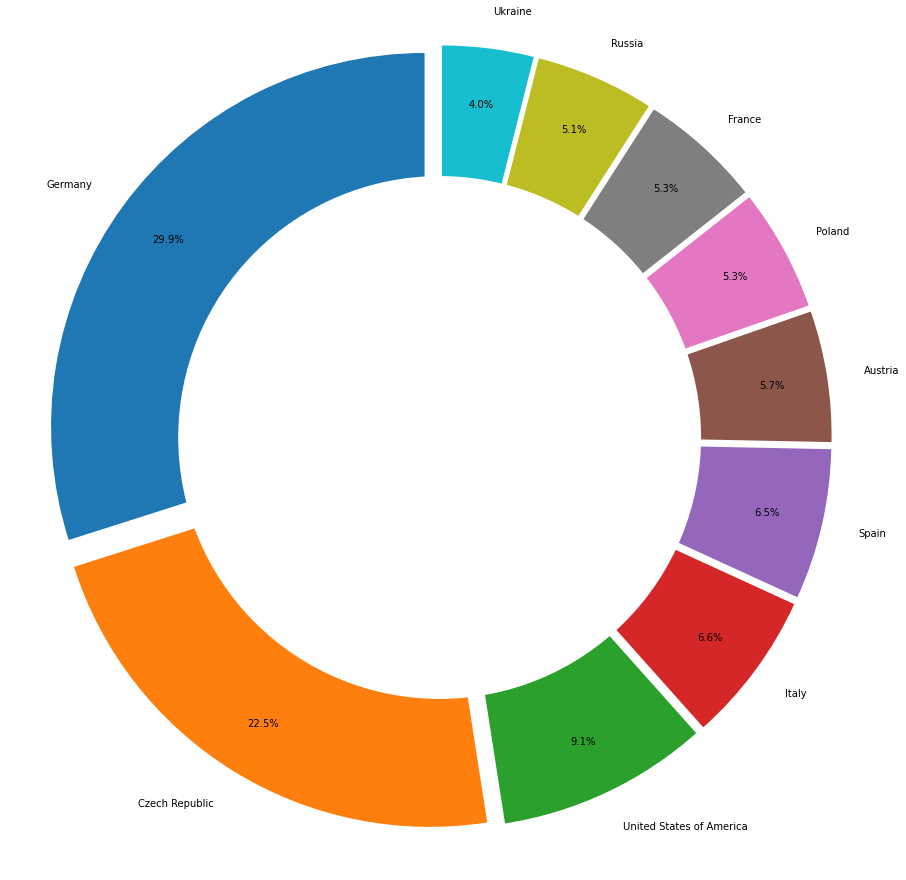

In [18]:
#prova ad usare i countrycode
l = len(birthplacefem_dict)
import matplotlib.pyplot as plt

# Data to plot
labels = []
sizes = []


a = 0.05
explode_list = []
for i in range(l):
    explode_list.append(a)

explode=tuple(explode_list)
print(explode)
    
fig = plt.figure(1, figsize=(15,15))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for x, y in birthplacefem_dict.items():
    labels.append(y[0])
    sizes.append(y[1])

# Plot
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout()


plt.show()

Now let's compare our results with the men

In [19]:
menbirthplace_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT ?placeofbirth ?placeofbirthLabel ?countryLabel (COUNT(?person) AS ?totmen)
WHERE
{
       ?person wdt:P31 wd:Q5 ;
            wdt:P21 wd:Q6581097 ;
            wdt:P106/wdt:P279* wd:Q1792450; 
            wdt:P19 ?placeofbirth.
           ?placeofbirth wdt:P17 ?country.
       
       SERVICE wikibase:label {bd:serviceParam wikibase:language "en" }
}
GROUP BY ?placeofbirth ?placeofbirthLabel ?countryLabel
ORDER BY DESC(?totmen)
"""
sparql_wd = SPARQLWrapper(wikidata_endpoint, agent='Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:47.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36')
sparql_wd.setQuery(menbirthplace_query)
sparql_wd.setReturnFormat(JSON)
menbirthplacesResults = sparql_wd.query().convert()

In [20]:
for result in menbirthplacesResults["results"]["bindings"]:
    birthplaces = result["placeofbirthLabel"]["value"]
    totaln = result["totmen"]["value"]
    country = result["countryLabel"]["value"]
    if result["totmen"]["value"] == str(1):
        print("There is "+ totaln +" " + "male art historian born in " + birthplaces + "  (" + country+ ")")
    else:
        print("There are "+ totaln + " " + "male art historians born in " + birthplaces + "  (" + country+ ")")

There are 217 male art historians born in Prague  (Czech Republic)
There are 192 male art historians born in Berlin  (Germany)
There are 162 male art historians born in Paris  (France)
There are 157 male art historians born in Vienna  (Austria)
There are 89 male art historians born in Budapest  (Hungary)
There are 87 male art historians born in Munich  (Germany)
There are 75 male art historians born in London  (United Kingdom)
There are 75 male art historians born in Rome  (Italy)
There are 71 male art historians born in Hamburg  (Germany)
There are 61 male art historians born in Dresden  (Germany)
There are 61 male art historians born in Moscow  (Russia)
There are 60 male art historians born in Saint Petersburg  (Russia)
There are 53 male art historians born in Cologne  (Germany)
There are 53 male art historians born in Leipzig  (Germany)
There are 50 male art historians born in Frankfurt am Main  (Germany)
There are 49 male art historians born in Warsaw  (Poland)
There are 49 male ar

There is 1 male art historian born in Holstebro  (Denmark)
There is 1 male art historian born in Sfax  (Tunisia)
There is 1 male art historian born in Ottersweier  (Germany)
There is 1 male art historian born in Zahrádky  (Czech Republic)
There is 1 male art historian born in Hoya  (Germany)
There is 1 male art historian born in Preston  (United Kingdom)
There is 1 male art historian born in Zhongxiang City  (People's Republic of China)
There is 1 male art historian born in Baranavichy  (Belarus)
There is 1 male art historian born in Bruneck  (Italy)
There is 1 male art historian born in Opladen  (Germany)
There is 1 male art historian born in Ninove  (Belgium)
There is 1 male art historian born in Wieliczka  (Poland)
There is 1 male art historian born in Boguszów  (Poland)
There is 1 male art historian born in Municipality of Polzela  (Slovenia)
There is 1 male art historian born in Redruth  (United Kingdom)
There is 1 male art historian born in Trelly  (France)
There is 1 male art hi

There is 1 male art historian born in Yezupil  (Austria-Hungary)
There is 1 male art historian born in Yezupil  (Austrian Empire)
There is 1 male art historian born in Radaškovičy  (Belarus)
There is 1 male art historian born in Misterhult  (Sweden)
There is 1 male art historian born in Caledonia  (Canada)
There is 1 male art historian born in Sånga församling  (Sweden)
There is 1 male art historian born in Mason City  (United States of America)
There is 1 male art historian born in Simferopol  (Russia)
There is 1 male art historian born in Simferopol  (Ukraine)
There is 1 male art historian born in Ware  (United Kingdom)
There is 1 male art historian born in Zhytomyr  (Ukraine)
There is 1 male art historian born in Nadvirna  (Ukraine)
There is 1 male art historian born in Nadvirna  (Austria-Hungary)
There is 1 male art historian born in Nadvirna  (Austrian Empire)
There is 1 male art historian born in Pyriatyn  (Ukraine)
There is 1 male art historian born in Žatec  (Czech Republic)
Th

There is 1 male art historian born in Vídeň  (Czech Republic)
There is 1 male art historian born in Bückeburg  (Germany)
There is 1 male art historian born in Kirchheimbolanden  (Germany)
There is 1 male art historian born in Odenthal  (Germany)
There is 1 male art historian born in Villach  (Austria)
There is 1 male art historian born in Kreiensen  (Germany)
There is 1 male art historian born in Schmölln  (Germany)
There is 1 male art historian born in Peitz  (Germany)
There is 1 male art historian born in Montabaur  (Germany)
There is 1 male art historian born in Kamenice nad Lipou  (Czech Republic)
There is 1 male art historian born in Groß-Gerau  (Germany)
There is 1 male art historian born in Prachatice  (Czech Republic)
There is 1 male art historian born in Melk  (Austria)
There is 1 male art historian born in Knittelfeld  (Austria)
There is 1 male art historian born in Kellinghusen  (Germany)
There is 1 male art historian born in Esthal  (Germany)
There is 1 male art historian b

In [21]:
import pandas as pd
import csv
df = pd.read_csv("birthplaceman.csv")
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df)
print(df[0:10])

                  countryLabel countryCode  totmen
0                      Germany          DE    2242
1               Czech Republic          CZ     785
2                       France          FR     623
3                        Italy          IT     531
4                       Poland          PL     369
5     United States of America          US     336
6                      Austria          AT     300
7               United Kingdom          GB     278
8                       Russia          RU     214
9                        Spain          ES     199
10                     Ukraine          UA     178
11                 Switzerland          CH     176
12                     Hungary          HU     172
13                 Netherlands          NL     160
14                     Belgium          BE     113
15                       Japan          JP     110
16                      Sweden          SE      92
17                     Romania          RO      75
18                    Slovenia 

In [22]:
birthplaceman_dict = {}
birthplaceman_list = df[0:10]
birthplaceman_dict = birthplaceman_list.set_index('countryCode').T.to_dict('list') 
print(birthplaceman_dict)

{'DE': ['Germany', 2242], 'CZ': ['Czech Republic', 785], 'FR': ['France', 623], 'IT': ['Italy', 531], 'PL': ['Poland', 369], 'US': ['United States of America', 336], 'AT': ['Austria', 300], 'GB': ['United Kingdom', 278], 'RU': ['Russia', 214], 'ES': ['Spain', 199]}


(0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)


<ipython-input-23-f2f614ae13e5>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


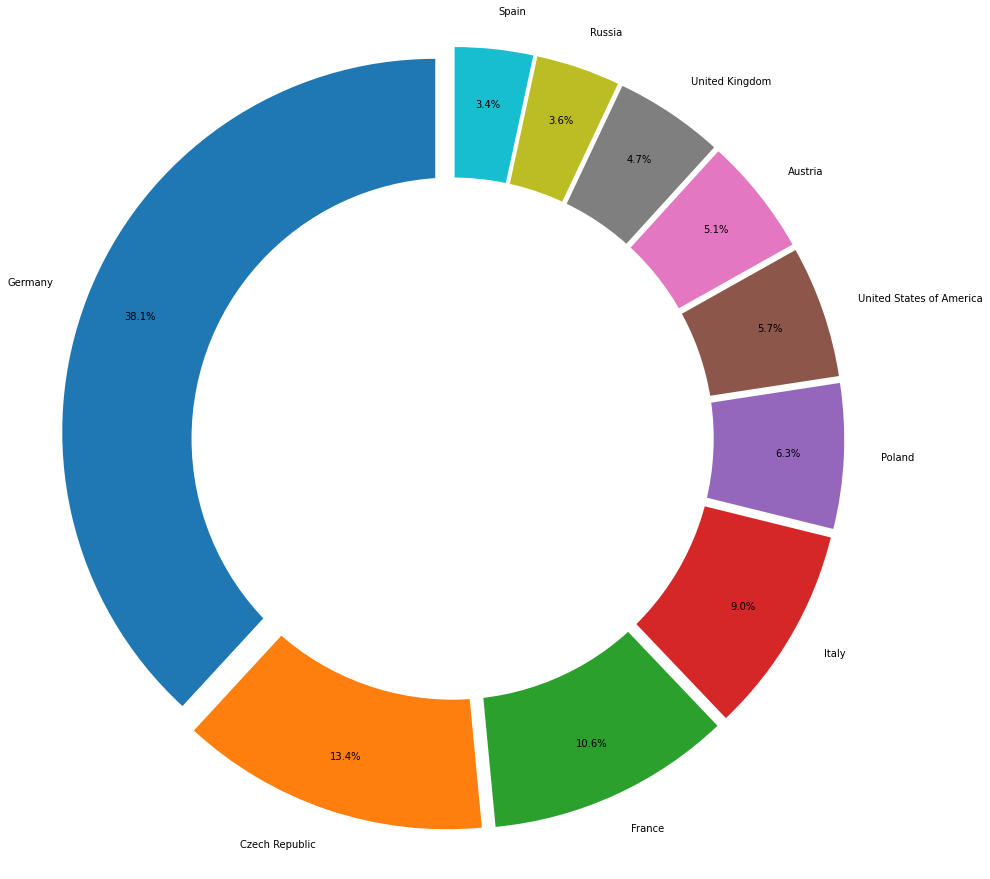

In [23]:
l = len(birthplaceman_dict)
import matplotlib.pyplot as plt

# Data to plot
labels = []
sizes = []


a = 0.05
explode_list = []
for i in range(l):
    explode_list.append(a)

explode=tuple(explode_list)
print(explode)
    
fig = plt.figure(1, figsize=(15,15))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for x, y in birthplaceman_dict.items():
    labels.append(y[0])
    sizes.append(y[1])

# Plot
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout()


plt.show()

Let's combine our results

In [25]:
#porcodio <3
import pandas as pd

birthplaces = {}
 #abbiamo indicizzato con le femmine quindi i valori sono inseriti in ordine crescente 
for res in fembirthplacesResults["results"]["bindings"] + menbirthplacesResults["results"]["bindings"]: #concatenazione liste 
    country = res["countryLabel"]["value"]
    #dentro il diz citizen prendi la chiave country che altrimenti sarebbe vuota e andiamo a popolarla, 
    #tutti gli stati che fanno parte di male o fem
    birthplaces[country] = {"fem": 0, "men": 0} #facciamo il diz con i placeholder che poi andremo a popolare, con zero diciamo che non c'è
#dal diz che non era nulla perchè era vuoto abbiamo un diz con tutte le parole che sono gli stati ma nesuno ha il nume di maschi
#e fem #per ora abbiamo messo a tutti la stessa definizone (nessuna 0 0 )
for res in fembirthplacesResults["results"]["bindings"]: #leggendo volta per volta mettiamo quello che ci serve 
    country = res["countryLabel"]["value"]
    birthplaces[country]["fem"] = res['totwomen']['value']
    
for res in menbirthplacesResults["results"]["bindings"]:
    country = res["countryLabel"]["value"]
    birthplaces[country]["men"] = res['totmen']['value']
birthplaces    
#data = pd.DataFrame(citizenship).transpose() #quando fai la lista ti prendi le chiavi con items,  con items crea delle tuple chiavi valori
#data

{'Czech Republic': {'fem': '1', 'men': '1'},
 'Austria': {'fem': '1', 'men': '1'},
 'Germany': {'fem': '1', 'men': '1'},
 'Hungary': {'fem': '1', 'men': '1'},
 'Russia': {'fem': '1', 'men': '1'},
 'Spain': {'fem': '1', 'men': '1'},
 'Italy': {'fem': '1', 'men': '1'},
 'Poland': {'fem': '1', 'men': '1'},
 'United Kingdom': {'fem': '1', 'men': '1'},
 'France': {'fem': '1', 'men': '1'},
 'United States of America': {'fem': '1', 'men': '1'},
 'Ukraine': {'fem': '1', 'men': '1'},
 'Slovenia': {'fem': '1', 'men': '1'},
 'Bulgaria': {'fem': '1', 'men': '1'},
 'Estonia': {'fem': '1', 'men': '1'},
 'Slovakia': {'fem': '1', 'men': '1'},
 'Japan': {'fem': '1', 'men': '1'},
 'Greece': {'fem': '1', 'men': '1'},
 'Netherlands': {'fem': '1', 'men': '1'},
 'Kingdom of the Netherlands': {'fem': '8', 'men': '32'},
 'Denmark': {'fem': '1', 'men': '1'},
 'Danish Realm': {'fem': '8', 'men': '23'},
 'Belarus': {'fem': '1', 'men': '1'},
 'Switzerland': {'fem': '1', 'men': '1'},
 'Armenia': {'fem': '1', 'men'

In [ ]:
#qua ci va l'istogramma 

## Citizenships 

Let's analyse the citizenship of the female art historians

In [36]:
countryfem_query= """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT ?countryCode ?countryLabel (COUNT(?person) AS ?totwomen)
WHERE
{
       ?person wdt:P31 wd:Q5 ;
            wdt:P21 wd:Q6581072 ;
            wdt:P106/wdt:P279* wd:Q1792450;
            wdt:P27 ?country.
       
       ?country wdt:P297 ?countryCode.
       SERVICE wikibase:label {bd:serviceParam wikibase:language "en" }
}
GROUP BY ?countryCode ?countryLabel
ORDER BY DESC(?totwomen)
"""
sparql_wd = SPARQLWrapper(wikidata_endpoint, agent='Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:47.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36')
sparql_wd.setQuery(countryfem_query)
sparql_wd.setReturnFormat(JSON)
femcountryResults = sparql_wd.query().convert()

In [37]:
countryfem = {}
countryfemlist = []
for result in femcountryResults["results"]["bindings"]:
    country = result["citizenshipLabel"]["value"]
    totaln = result["totwomen"]["value"]
    countryfem[country] = totaln
    countryfemlist.append(int(totaln))
    if result["totwomen"]["value"] == str(1):
        print("There is "+ totaln +" " + " female art historian in " + country)
    else:
        print("There are "+ totaln + " " + " female art historians in " + country)

KeyError: 'citizenshipLabel'

Let's plot our results in a piechart using a pandas df

In [29]:
import pandas as pd
import csv
df = pd.read_csv("country_fem.csv")
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df)
print(df[0:18])

   countryCode                countryLabel  totwomen
0           DE                     Germany       473
1           US    United States of America       360
2           FR                      France       201
3           IT                       Italy       160
4           ES                       Spain       152
5           SI                    Slovenia       136
6           PL                      Poland       122
7           GB              United Kingdom       111
8           AT                     Austria       103
9           RU                      Russia        80
10          NL  Kingdom of the Netherlands        74
11          CZ              Czech Republic        71
12          CH                 Switzerland        60
13          HU                     Hungary        58
14          NO                      Norway        57
15          CA                      Canada        56
16          SE                      Sweden        54
17          DK                     Denmark    

In [30]:
#for readability reason of the visualization are taken into consideration the first 17 countries, to see graphically what are the 
countryfem_dict = {}
countryfem_list = df[0:18]
countryfem_dict = countryfem_list.set_index('countryCode').T.to_dict('list') 
print(countryfem_dict)

{'DE': ['Germany', 473], 'US': ['United States of America', 360], 'FR': ['France', 201], 'IT': ['Italy', 160], 'ES': ['Spain', 152], 'SI': ['Slovenia', 136], 'PL': ['Poland', 122], 'GB': ['United Kingdom', 111], 'AT': ['Austria', 103], 'RU': ['Russia', 80], 'NL': ['Kingdom of the Netherlands', 74], 'CZ': ['Czech Republic', 71], 'CH': ['Switzerland', 60], 'HU': ['Hungary', 58], 'NO': ['Norway', 57], 'CA': ['Canada', 56], 'SE': ['Sweden', 54], 'DK': ['Denmark', 52]}


(0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)


<ipython-input-31-1c84d3045002>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


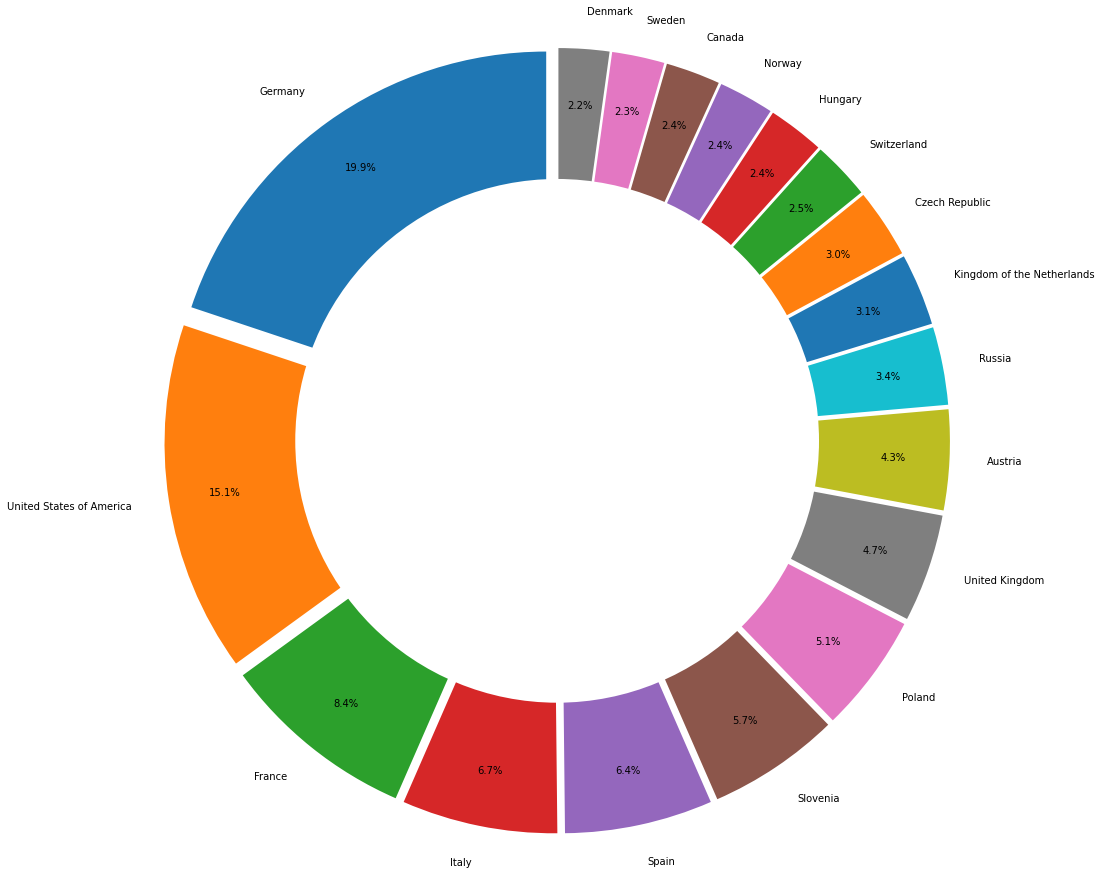

In [31]:
l = len(countryfem_dict)
import matplotlib.pyplot as plt

# Data to plot
labels = []
sizes = []


a = 0.05
explode_list = []
for i in range(l):
    explode_list.append(a)

explode=tuple(explode_list)
print(explode)
    
fig = plt.figure(1, figsize=(15,15))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for x, y in countryfem_dict.items():
    labels.append(y[0])
    sizes.append(y[1])

# Plot
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout()


plt.show()

Now let's check the number of male art historians to see if there are differences

In [32]:
countrymen_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT ?countryCode ?countryLabel (COUNT(?person) AS ?totmen)
WHERE
{
       ?person wdt:P31 wd:Q5 ;
            wdt:P21 wd:Q6581097 ;
            wdt:P106/wdt:P279* wd:Q1792450;
            wdt:P27 ?country.
       
       ?country wdt:P297 ?countryCode.
       SERVICE wikibase:label {bd:serviceParam wikibase:language "en" }
}
GROUP BY ?countryCode ?countryLabel
ORDER BY DESC(?totmen)
"""
sparql_wd = SPARQLWrapper(wikidata_endpoint, agent='Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:47.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36')
sparql_wd.setQuery(countrymen_query)
sparql_wd.setReturnFormat(JSON)
mencountryResults = sparql_wd.query().convert()

In [33]:
countrymen = {}
countrymenlist = []
countrymenlistviz = []
for result in mencountryResults["results"]["bindings"]:
    country = result["countryLabel"]["value"]
    totaln = result["totmen"]["value"]
    countrymen[country] = totaln
    countrymenlist.append(int(totaln))
    
    if result["totmen"]["value"] == str(1):
        print("There is "+ totaln +" " + " male art historian in " + country)
    else:
        print("There are "+ totaln + " " + " male art historians in " + country)

There are 1887  male art historians in Germany
There are 776  male art historians in France
There are 595  male art historians in United States of America
There are 391  male art historians in United Kingdom
There are 364  male art historians in Italy
There are 340  male art historians in Austria
There are 260  male art historians in Poland
There are 241  male art historians in Spain
There are 216  male art historians in Switzerland
There are 194  male art historians in Kingdom of the Netherlands
There are 167  male art historians in Japan
There are 161  male art historians in Hungary
There are 147  male art historians in Sweden
There are 127  male art historians in Czech Republic
There are 123  male art historians in Belgium
There are 109  male art historians in Denmark
There are 102  male art historians in Slovenia
There are 102  male art historians in Russia
There are 95  male art historians in Norway
There are 70  male art historians in Canada
There are 45  male art historians in G

Let's have a pie chart to have visual representations of the results using a pandas df

In [34]:
import pandas as pd
import csv
df = pd.read_csv("country_men.csv")
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df)
print(df[0:18])

   countryCode                countryLabel  totmen
0           DE                     Germany    1888
1           FR                      France     772
2           US    United States of America     595
3           GB              United Kingdom     390
4           IT                       Italy     364
5           AT                     Austria     340
6           PL                      Poland     260
7           ES                       Spain     241
8           CH                 Switzerland     216
9           NL  Kingdom of the Netherlands     194
10          JP                       Japan     167
11          HU                     Hungary     160
12          SE                      Sweden     147
13          CZ              Czech Republic     126
14          BE                     Belgium     123
15          DK                     Denmark     104
16          SI                    Slovenia     102
17          RU                      Russia     102
18          NO                 

In [35]:
#for readability reason of the visualization are taken into consideration the first 17 countries, to see graphically what are the 
countrymale_dict = {}
countrymale_list = df[0:18]
countrymale_dict = countrymale_list.set_index('countryCode').T.to_dict('list') 
print(countrymale_dict)

{'DE': ['Germany', 1888], 'FR': ['France', 772], 'US': ['United States of America', 595], 'GB': ['United Kingdom', 390], 'IT': ['Italy', 364], 'AT': ['Austria', 340], 'PL': ['Poland', 260], 'ES': ['Spain', 241], 'CH': ['Switzerland', 216], 'NL': ['Kingdom of the Netherlands', 194], 'JP': ['Japan', 167], 'HU': ['Hungary', 160], 'SE': ['Sweden', 147], 'CZ': ['Czech Republic', 126], 'BE': ['Belgium', 123], 'DK': ['Denmark', 104], 'SI': ['Slovenia', 102], 'RU': ['Russia', 102]}


(0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)


<ipython-input-36-e3dcefd5d1a1>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


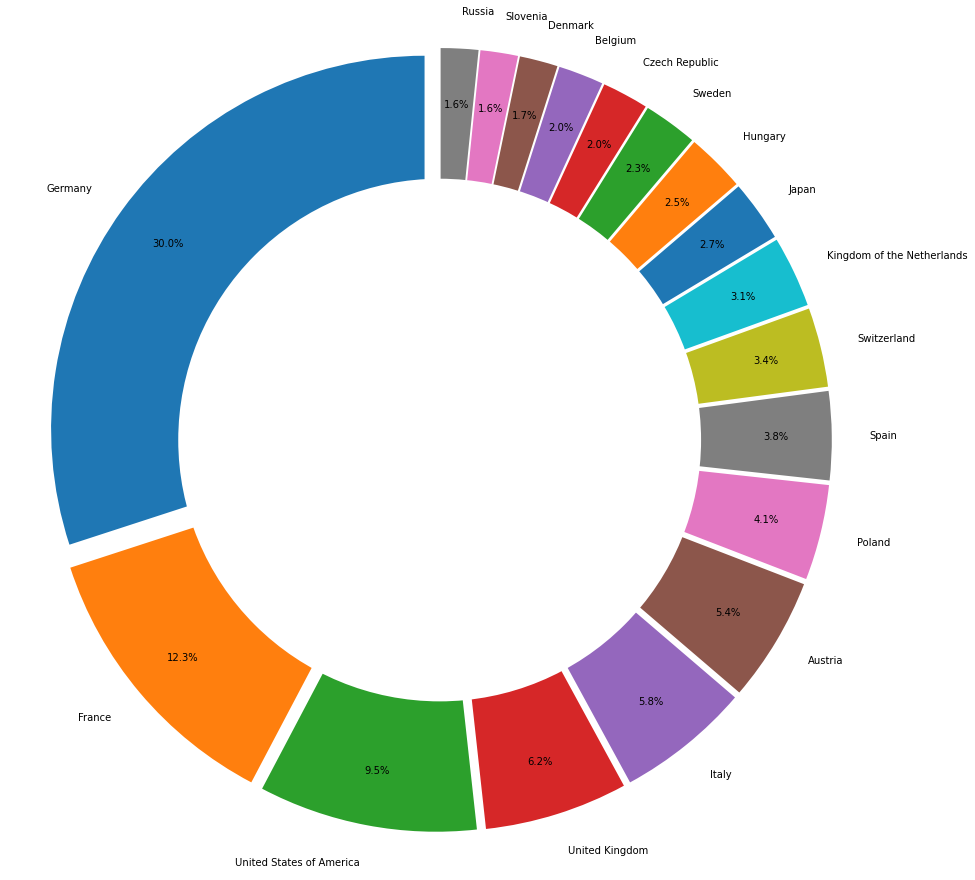

In [36]:
l = len(countrymale_dict)
import matplotlib.pyplot as plt

# Data to plot
labels = []
sizes = []


a = 0.05
explode_list = []
for i in range(l):
    explode_list.append(a)

explode=tuple(explode_list)
print(explode)
    
fig = plt.figure(1, figsize=(15,15))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for x, y in countrymale_dict.items():
    labels.append(y[0])
    sizes.append(y[1])

# Plot
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout()


plt.show()

Now let's combine the results to see the differences:

In [37]:
#PROBLEMA HO PROVATO AD UNIRE I RISULTATI QUA, NON USANDO PANDAS MA USANDO LE VARIABILI CHE HO ESTRATTO DIRETTAMENTE DALLE QUERY
#VORREI CREARE UN ISTOGRAMMA CHE METTA IN RELAZIONE I RISULATI DI UOMINI/DONNE SUDDIVISI PER NAZIONE
import pandas as pd

citizenship = {}
 #abbiamo indicizzato con le femmine quindi i valori sono inseriti in ordine crescente 
for res in femcountryResults["results"]["bindings"] + mencountryResults["results"]["bindings"]: #concatenazione liste 
    country = res["countryLabel"]["value"]
    #dentro il diz citizen prendi la chiave country che altrimenti sarebbe vuota e andiamo a popolarla, 
    #tutti gli stati che fanno parte di male o fem
    citizenship[country] = {"fem": 0, "men": 0} #facciamo il diz con i placeholder che poi andremo a popolare, con zero diciamo che non c'è
#dal diz che non era nulla perchè era vuoto abbiamo un diz con tutte le parole che sono gli stati ma nesuno ha il nume di maschi
#e fem #per ora abbiamo messo a tutti la stessa definizone (nessuna 0 0 )
for res in femcountryResults["results"]["bindings"]: #leggendo volta per volta mettiamo quello che ci serve 
    country = res["countryLabel"]["value"]
    citizenship[country]["fem"] = res['totwomen']['value']
    
for res in mencountryResults["results"]["bindings"]:
    country = res["countryLabel"]["value"]
    citizenship[country]["men"] = res['totmen']['value']
citizenship   
#for key, value in citizenship.items():
 # print(key)
  #print(str(value))
#data = pd.DataFrame(citizenship).transpose() #quando fai la lista ti prendi le chiavi con items,  con items crea delle tuple chiavi valori
#data

{'Germany': {'fem': '474', 'men': '1887'},
 'United States of America': {'fem': '361', 'men': '595'},
 'France': {'fem': '202', 'men': '776'},
 'Italy': {'fem': '161', 'men': '364'},
 'Spain': {'fem': '154', 'men': '241'},
 'Slovenia': {'fem': '136', 'men': '102'},
 'Poland': {'fem': '123', 'men': '260'},
 'United Kingdom': {'fem': '111', 'men': '391'},
 'Austria': {'fem': '103', 'men': '340'},
 'Russia': {'fem': '81', 'men': '102'},
 'Kingdom of the Netherlands': {'fem': '74', 'men': '194'},
 'Czech Republic': {'fem': '71', 'men': '127'},
 'Switzerland': {'fem': '60', 'men': '216'},
 'Hungary': {'fem': '58', 'men': '161'},
 'Norway': {'fem': '57', 'men': '95'},
 'Canada': {'fem': '56', 'men': '70'},
 'Sweden': {'fem': '54', 'men': '147'},
 'Denmark': {'fem': '52', 'men': '109'},
 'Estonia': {'fem': '42', 'men': '37'},
 'Japan': {'fem': '29', 'men': '167'},
 'Finland': {'fem': '29', 'men': '43'},
 'Ukraine': {'fem': '27', 'men': '36'},
 'Belgium': {'fem': '27', 'men': '123'},
 'Israel'

In [38]:
citiz = pd.DataFrame(citizenship).transpose()
citiz
country_citiz = citiz.iloc[:10]
country_citiz

,fem,men
Germany,474,1887
United States of America,361,595
France,202,776
Italy,161,364
Spain,154,241
Slovenia,136,102
Poland,123,260
United Kingdom,111,391
Austria,103,340
Russia,81,102


In [39]:
list_country=[]
list_fem = []
list_male =[]
for key, value in citizenship.items():
  list_country.append(key)
  list_fem.append(str(list(value.values())[0]))
  list_male.append(str(list(value.values())[1]))

data = {'Country':list_country, 'Fem':list_fem, 'Male':list_male}
data = df[:10]
data
import pandas as pd
df = pd.DataFrame(data)

print(df)

  countryCode                countryLabel  totmen
0          DE                     Germany    1888
1          FR                      France     772
2          US    United States of America     595
3          GB              United Kingdom     390
4          IT                       Italy     364
5          AT                     Austria     340
6          PL                      Poland     260
7          ES                       Spain     241
8          CH                 Switzerland     216
9          NL  Kingdom of the Netherlands     194


In [191]:
from math import pi

import pandas as pd

from bokeh.io import output_notebook, show
from bokeh.palettes import Category20c
from bokeh.plotting import figure
from bokeh.transform import cumsum

output_notebook()
gender = ["male", "female"]
colors = ["#c4ddda", "#e8cdda"]

data = df#{'Country' : list_country,
        #'Fem'   : list_fem,
        #'Male' : list_male}

p = figure(x_range=list_country,  plot_width=1000, plot_height=500, title="Gender of art historians divided per citizenship",
           toolbar_location=None, tools="hover")

p.vbar_stack(gender, x='country', width=0.9, color=colors, source=data,
             legend_label=gender)

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"
p.xaxis.major_label_orientation = "vertical"

show(p)

Loading BokehJS ...

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)
df = sns.load_dataset("data")
sns.catplot(x="Country", y="Fem", hue="sex", kind="bar", data=data)

ValueError: 'data' is not one of the example datasets.

In [45]:
data = pd.DataFrame(citizenship).transpose() #quando fai la lista ti prendi le chiavi con items,  con items crea delle tuple chiavi valori
data
data = data[:10]
data

,fem,men
Germany,473,1887
United States of America,361,595
France,202,774
Italy,161,364
Spain,154,241
Slovenia,136,102
Poland,123,260
United Kingdom,111,391
Austria,103,340
Russia,81,102


For a better visual representation the query is modified to have just the countries, we make the df about it and then plot it using seaborn

### Place of education

In [3]:
educationfem_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT ?educatedatLabel ?countryLabel  (COUNT(?person) AS ?totwomen)

WHERE
{
       ?person wdt:P31 wd:Q5 ;
            wdt:P21 wd:Q6581072 ;
            wdt:P106/wdt:P279* wd:Q1792450;
            wdt:P69 ?educatedat;
            wdt:P27 ?country.
  SERVICE wikibase:label { 
    bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". 
    ?educatedat rdfs:label ?educatedatLabel .
    ?country     rdfs:label ?countryLabel .
  
  }

       
}
GROUP BY ?educatedatLabel ?countryLabel
ORDER BY DESC(?totwomen)
"""
sparql_wd = SPARQLWrapper(wikidata_endpoint, agent='Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:47.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36')
sparql_wd.setQuery(educationfem_query)
sparql_wd.setReturnFormat(JSON)
educationfemResults = sparql_wd.query().convert()

eduplaceman_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT ?educatedatLabel ?countryLabel  (COUNT(?person) AS ?totmen)

WHERE
{
       ?person wdt:P31 wd:Q5 ;
            wdt:P21 wd:Q6581097 ;
            wdt:P106/wdt:P279* wd:Q1792450;
            wdt:P69 ?educatedat;
            wdt:P27 ?country.
  SERVICE wikibase:label { 
    bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". 
    ?educatedat rdfs:label ?educatedatLabel .
    ?country     rdfs:label ?countryLabel .
  
  }

       
}
GROUP BY ?educatedatLabel ?countryLabel
ORDER BY DESC(?totmen)
"""
sparql_wd = SPARQLWrapper(wikidata_endpoint, agent='Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:47.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36')
sparql_wd.setQuery(eduplaceman_query)
sparql_wd.setReturnFormat(JSON)
educationmanResults = sparql_wd.query().convert()


women edu:  87 
men edu:  129 
tot:  149


{'United States of America': {'women': 487, 'men': 684},
 'France': {'women': 143, 'men': 446},
 'Germany': {'women': 125, 'men': 519},
 'Spain': {'women': 123, 'men': 147},
 'United Kingdom': {'women': 108, 'men': 440},
 'Soviet Union': {'women': 105, 'men': 216},
 'Poland': {'women': 90, 'men': 196},
 'Russia': {'women': 66, 'men': 95},
 'Canada': {'women': 49, 'men': 57},
 'Italy': {'women': 42, 'men': 135}}

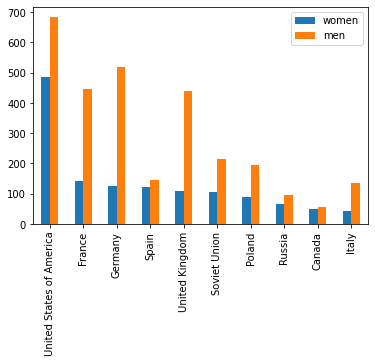

In [4]:
get_women_man_differences(womenResults = educationfemResults["results"]["bindings"],
                          manResults = educationmanResults["results"]["bindings"],
                          label = "educatedatLabel")

In [42]:
universityfem = {}
universityfemlist = []
for result in educationfemResults["results"]["bindings"]:
    country = result["countryLabel"]["value"]
    totaln = result["totwomen"]["value"]
    university = result["educatedatLabel"]["value"]
    universityfem[country] = totaln
    universityfemlist.append(int(totaln))
    if result["totwomen"]["value"] == str(1):
        print("There is "+ totaln +" " + " female art historian that have studied in "  + university +  "  (" + country+ ")")
    else:
        print("There are "+ totaln + " " + " female art historians that have studied in " + university +  "  (" + country+ ")")

There are 34  female art historians that have studied in University of Warsaw  (Poland)
There are 33  female art historians that have studied in Columbia University  (United States of America)
There are 32  female art historians that have studied in École du Louvre  (France)
There are 29  female art historians that have studied in University of Vienna  (Austria)
There are 27  female art historians that have studied in Harvard University  (United States of America)
There are 23  female art historians that have studied in University of Barcelona  (Spain)
There are 21  female art historians that have studied in Complutense University of Madrid  (Spain)
There are 19  female art historians that have studied in Jagiellonian University  (Poland)
There are 18  female art historians that have studied in Barnard College  (United States of America)
There are 17  female art historians that have studied in Eötvös Loránd University  (Hungary)
There are 15  female art historians that have studied in 

In [81]:
universitymen = {}
universitymenlist = []
for result in eduplacemanResults["results"]["bindings"]:
    country = result["countryLabel"]["value"]
    totaln = result["totmen"]["value"]
    university = result["educatedatLabel"]["value"]
    universitymen[country] = totaln
    universitymenlist.append(int(totaln))
    if result["totmen"]["value"] == str(1):
        print("There is "+ totaln +" " + " male art historian that have studied in "  + university +  "  (" + country+ ")")
    else:
        print("There are "+ totaln + " " + " male art historians that have studied in " + university +  "  (" + country+ ")")

There are 92  male art historians that have studied in Harvard University  (United States of America)
There are 79  male art historians that have studied in University of Vienna  (Austria)
There are 57  male art historians that have studied in University of Tokyo  (Japan)
There are 54  male art historians that have studied in University of Bonn  (Germany)
There are 53  male art historians that have studied in École normale supérieure  (Paris)  (France)
There are 53  male art historians that have studied in École des Chartes  (France)
There are 49  male art historians that have studied in Faculty of Arts, Charles University in Prague  (Czechoslovakia)
There are 48  male art historians that have studied in École du Louvre  (France)
There are 44  male art historians that have studied in Jagiellonian University  (Poland)
There are 42  male art historians that have studied in Ludwig Maximilian University of Munich  (Germany)
There are 42  male art historians that have studied in Yale Univer

There is 1  male art historian that have studied in Downside School  (United Kingdom)
There is 1  male art historian that have studied in Harrow School  (United Kingdom of Great Britain and Ireland)
There is 1  male art historian that have studied in Rossall School  (United Kingdom)
There is 1  male art historian that have studied in Western Reserve Academy  (United States of America)
There is 1  male art historian that have studied in Technical University of Madrid  (Spain)
There is 1  male art historian that have studied in Courtauld Institute of Art  (Canada)
There is 1  male art historian that have studied in The King's School Canterbury  (United Kingdom)
There is 1  male art historian that have studied in University of Göttingen  (Denmark)
There is 1  male art historian that have studied in Leipzig University  (Denmark)
There is 1  male art historian that have studied in Accademia di Belle Arti di Venezia  (Kingdom of Italy)
There is 1  male art historian that have studied in lycé

There is 1  male art historian that have studied in Ohio State University  (United States of America)
There is 1  male art historian that have studied in Principia College  (United States of America)
There is 1  male art historian that have studied in Warburg Institute  (Spain)
There is 1  male art historian that have studied in King's College  (Spain)
There is 1  male art historian that have studied in Repin Institute of Arts  (France)
There is 1  male art historian that have studied in Facultad de Filosofía y Letras (Universidad Autónoma de Madrid)  (Spain)
There is 1  male art historian that have studied in Polytechnic University of Valencia  (Spain)
There is 1  male art historian that have studied in Moscow State University  (Russian Soviet Federative Socialist Republic)
There is 1  male art historian that have studied in Donghua University  (People's Republic of China)
There is 1  male art historian that have studied in Reinwardt Academie  (Kingdom of the Netherlands)
There is 1  

### Institute in which arthistorians work the most

In [93]:
feminstitute_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT ?institutionLabel ?countryLabel  (count(?person) as ?totwomen) WHERE {
  
  ?person wdt:P31 wd:Q5; 
             wdt:P21 wd:Q6581072;
            wdt:P106/wdt:P279* wd:Q1792450;
             wdt:P463 ?institution.
            ?institution wdt:P17 ?country.
    ?country wdt:P297 ?countryCode.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  
}

GROUP BY ?institutionLabel  ?countryLabel
ORDER BY DESC (?totwomen)
"""
sparql_wd = SPARQLWrapper(wikidata_endpoint, agent='Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:47.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36')
sparql_wd.setQuery(feminstitute_query)
sparql_wd.setReturnFormat(JSON)
feminstituteResults = sparql_wd.query().convert()



In [94]:
institutefem = {}
intitutefemlist = []
for result in feminstituteResults["results"]["bindings"]:
    country = result["countryLabel"]["value"]
    totaln = result["totwomen"]["value"]
    institute = result["institutionLabel"]["value"]
    institutefem[country] = totaln
    intitutefemlist.append(int(totaln))
    if result["totwomen"]["value"] == str(1):
        print("There is "+ totaln +" " + " female art historian that works in "  + institute +  "  (" + country+ ")")
    else:
        print("There are "+ totaln + " " + " female art historians that work in " + institute +  "  (" + country+ ")")

There are 48  female art historians that work in German Archaeological Institute  (Germany)
There are 18  female art historians that work in American Academy of Arts and Sciences  (United States of America)
There are 13  female art historians that work in Academia Europaea  (United Kingdom)
There are 12  female art historians that work in Royal Swedish Academy of Letters, History and Antiquities  (Sweden)
There are 10  female art historians that work in Medieval Academy of America  (United States of America)
There are 8  female art historians that work in British Academy  (United Kingdom)
There are 7  female art historians that work in Real Academia de Bellas Artes de San Fernando  (Spain)
There are 6  female art historians that work in Mommsen Society  (Germany)
There are 6  female art historians that work in Reial Acadèmia Catalana de Belles Arts de Sant Jordi  (Spain)
There are 6  female art historians that work in College Art Association  (United States of America)
There are 6  fem

In [43]:
maleinstitute_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT ?institutionLabel ?countryLabel  (count(?person) as ?totmen) WHERE {
  
  ?person wdt:P31 wd:Q5; 
             wdt:P21 wd:Q6581072;
            wdt:P106/wdt:P279* wd:Q1792450;
             wdt:P463 ?institution.
            ?institution wdt:P17 ?country.
    ?country wdt:P297 ?countryCode.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  
}

GROUP BY ?institutionLabel  ?countryLabel
ORDER BY DESC (?totmen)
"""
sparql_wd = SPARQLWrapper(wikidata_endpoint, agent='Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:47.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36')
sparql_wd.setQuery(maleinstitute_query)
sparql_wd.setReturnFormat(JSON)
maleinstituteResults = sparql_wd.query().convert()

In [44]:

institutemen = {}
intitutemenlist = []
for result in maleinstituteResults["results"]["bindings"]:
    country = result["countryLabel"]["value"]
    totaln = result["totmen"]["value"]
    institute = result["institutionLabel"]["value"]
    institutemen[country] = totaln
    intitutemenlist.append(int(totaln))
    if result["totmen"]["value"] == str(1):
        print("There is "+ totaln +" " + " male art historian that works in "  + institute +  "  (" + country+ ")")
    else:
        print("There are "+ totaln + " " + " male art historians that work in " + institute +  "  (" + country+ ")")

There are 48  male art historians that work in German Archaeological Institute  (Germany)
There are 18  male art historians that work in American Academy of Arts and Sciences  (United States of America)
There are 13  male art historians that work in Academia Europaea  (United Kingdom)
There are 12  male art historians that work in Royal Swedish Academy of Letters, History and Antiquities  (Sweden)
There are 10  male art historians that work in Medieval Academy of America  (United States of America)
There are 8  male art historians that work in British Academy  (United Kingdom)
There are 7  male art historians that work in Real Academia de Bellas Artes de San Fernando  (Spain)
There are 6  male art historians that work in Mommsen Society  (Germany)
There are 6  male art historians that work in Reial Acadèmia Catalana de Belles Arts de Sant Jordi  (Spain)
There are 6  male art historians that work in College Art Association  (United States of America)
There are 6  male art historians tha

Combine the results:

In [97]:

import pandas as pd

workplaces = {}
 #abbiamo indicizzato con le femmine quindi i valori sono inseriti in ordine crescente 
for res in feminstituteResults["results"]["bindings"] + maleinstituteResults["results"]["bindings"]: #concatenazione liste 
    country = res["countryLabel"]["value"]
    #dentro il diz citizen prendi la chiave country che altrimenti sarebbe vuota e andiamo a popolarla, 
    #tutti gli stati che fanno parte di male o fem
    workplaces[country] = {"fem": 0, "men": 0} #facciamo il diz con i placeholder che poi andremo a popolare, con zero diciamo che non c'è
#dal diz che non era nulla perchè era vuoto abbiamo un diz con tutte le parole che sono gli stati ma nesuno ha il nume di maschi
#e fem #per ora abbiamo messo a tutti la stessa definizone (nessuna 0 0 )
for res in feminstituteResults["results"]["bindings"]: #leggendo volta per volta mettiamo quello che ci serve 
    country = res["countryLabel"]["value"]
    workplaces[country]["fem"] = res['totwomen']['value']
    
for res in maleinstituteResults["results"]["bindings"]:
    country = res["countryLabel"]["value"]
    workplaces[country]["men"] = res['totmen']['value']
citizenship    
#data = pd.DataFrame(citizenship).transpose() #quando fai la lista ti prendi le chiavi con items,  con items crea delle tuple chiavi valori
#data

{'Germany': {'fem': '473', 'men': '1887'},
 'United States of America': {'fem': '361', 'men': '595'},
 'France': {'fem': '202', 'men': '774'},
 'Italy': {'fem': '161', 'men': '364'},
 'Spain': {'fem': '154', 'men': '241'},
 'Slovenia': {'fem': '136', 'men': '102'},
 'Poland': {'fem': '123', 'men': '260'},
 'United Kingdom': {'fem': '111', 'men': '391'},
 'Austria': {'fem': '103', 'men': '340'},
 'Russia': {'fem': '81', 'men': '102'},
 'Kingdom of the Netherlands': {'fem': '74', 'men': '194'},
 'Czech Republic': {'fem': '71', 'men': '127'},
 'Switzerland': {'fem': '60', 'men': '216'},
 'Hungary': {'fem': '58', 'men': '160'},
 'Norway': {'fem': '57', 'men': '95'},
 'Canada': {'fem': '56', 'men': '70'},
 'Sweden': {'fem': '54', 'men': '147'},
 'Denmark': {'fem': '52', 'men': '109'},
 'Estonia': {'fem': '42', 'men': '37'},
 'Japan': {'fem': '29', 'men': '167'},
 'Finland': {'fem': '29', 'men': '43'},
 'Ukraine': {'fem': '27', 'men': '36'},
 'Belgium': {'fem': '27', 'men': '123'},
 'Israel'

### Occupations among art historians

In [35]:
femoccupation_query ="""
SELECT DISTINCT ?occupationLabel (COUNT(?person) AS ?totwomen)
WHERE
{
       ?person wdt:P31 wd:Q5 ;
              wdt:P21 wd:Q6581072;
              wdt:P106/wdt:P279* wd:Q1792450;
              wdt:P106 ?occupation ;
       
       SERVICE wikibase:label {bd:serviceParam wikibase:language "en" }
}
GROUP BY ?occupationLabel
ORDER BY DESC(?totwomen)
"""
sparql_wd = SPARQLWrapper(wikidata_endpoint, agent='Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:47.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36')
sparql_wd.setQuery(femoccupation_query)
sparql_wd.setReturnFormat(JSON)
femoccupationResults = sparql_wd.query().convert()

In [36]:
import pandas as pd
import csv
df = pd.read_csv("occupation.csv")
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df)


                       occupationLabel  totwoman
0                        art historian      4818
1                   university teacher       405
2                            historian       404
3                   exhibition curator       383
4                              curator       340
5                               writer       337
6                        archaeologist       181
7              architectural historian       159
8                           art critic       149
9                           journalist       131
10                          translator       109
11                  opinion journalist       104
12                              author       100
13                             teacher        98
14                           professor        84
15                             painter        78
16                     museum director        78
17                         museologist        68
18                           librarian        57
19                  

In [37]:
datawoman = df.drop([0], axis=0 ) #pandas method for cutting a single row delete all rows with the first label
print(datawoman)


                       occupationLabel  totwoman
1                   university teacher       405
2                            historian       404
3                   exhibition curator       383
4                              curator       340
5                               writer       337
6                        archaeologist       181
7              architectural historian       159
8                           art critic       149
9                           journalist       131
10                          translator       109
11                  opinion journalist       104
12                              author       100
13                             teacher        98
14                           professor        84
15                             painter        78
16                     museum director        78
17                         museologist        68
18                           librarian        57
19                           architect        55
20                  

In [38]:
#among the results we decide to take the first most significan 10, in order to graph to them 
#DataFrame as a Dictionary, access its columns using the indexing [] notation
#iloc is a pandas method for specific operators for rows/columns selection, odataframe.iloc[where_i,where_j]
#index-based selection, i.e. select rows and columns by integer position
#where_i is the row number (: otherwise), where_j is the column number (can be omitted).
occupationwomen = df.iloc[1:11] 
print(occupationwomen)

            occupationLabel  totwoman
1        university teacher       405
2                 historian       404
3        exhibition curator       383
4                   curator       340
5                    writer       337
6             archaeologist       181
7   architectural historian       159
8                art critic       149
9                journalist       131
10               translator       109


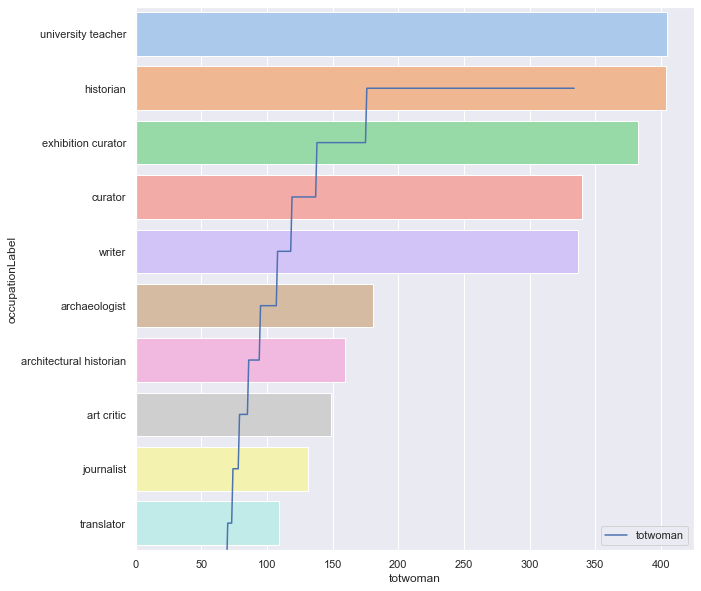

In [39]:
#plot the count
import seaborn as sns
import matplotlib.pyplot as plt

# Apply the default theme
sns.set_theme()
df.plot(figsize=(10,10))
my_graph = sns.barplot(y="occupationLabel", x ="totwoman", palette="pastel", data= occupationwomen)

In [56]:
menoccupation_query = """
SELECT DISTINCT ?occupationLabel (COUNT(?person) AS ?totmen)
WHERE
{
       ?person wdt:P31 wd:Q5 ;
              wdt:P21 wd:Q6581097;
              wdt:P106/wdt:P279* wd:Q1792450;
              wdt:P106 ?occupation ;
       
       SERVICE wikibase:label {bd:serviceParam wikibase:language "en" }
}
GROUP BY ?occupationLabel
ORDER BY DESC(?totmen)
"""
sparql_wd = SPARQLWrapper(wikidata_endpoint, agent='Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:47.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36')
sparql_wd.setQuery(menoccupation_query)
sparql_wd.setReturnFormat(JSON)
menoccupationResults = sparql_wd.query().convert()

In [40]:
import pandas as pd
import csv
df = pd.read_csv("occupationmale_query.csv")
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df)

                                       occupationLabel  totmen
0                                        art historian   10258
1                                   university teacher    1785
2                                        archaeologist    1091
3                                            historian    1013
4                                               writer     999
5                              architectural historian     765
6                                              painter     603
7                                            architect     556
8                                              curator     510
9                                           art critic     461
10                                  exhibition curator     422
11                                             teacher     389
12                                          journalist     363
13                                      anthropologist     274
14                                     museum director 

In [41]:
datamen = df.drop([0], axis=0 ) #pandas method for cutting a single row delete all rows with the first label
print(datamen)

                                       occupationLabel  totmen
1                                   university teacher    1785
2                                        archaeologist    1091
3                                            historian    1013
4                                               writer     999
5                              architectural historian     765
6                                              painter     603
7                                            architect     556
8                                              curator     510
9                                           art critic     461
10                                  exhibition curator     422
11                                             teacher     389
12                                          journalist     363
13                                      anthropologist     274
14                                     museum director     261
15                                                poet 

In [42]:
occupationmen = df.iloc[1:11] 
print(occupationmen)

            occupationLabel  totmen
1        university teacher    1785
2             archaeologist    1091
3                 historian    1013
4                    writer     999
5   architectural historian     765
6                   painter     603
7                 architect     556
8                   curator     510
9                art critic     461
10       exhibition curator     422


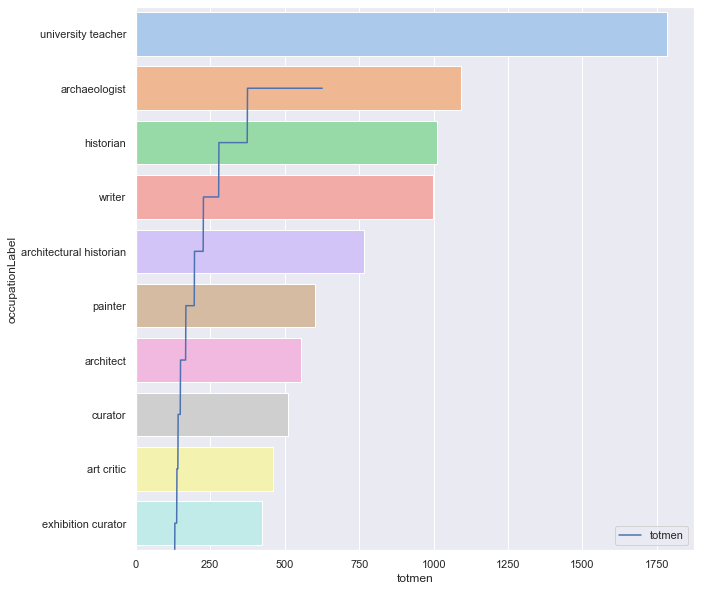

In [43]:
#plot the count
import seaborn as sns
import matplotlib.pyplot as plt

# Apply the default theme
sns.set_theme()
df.plot(figsize=(10,10))
my_graph = sns.barplot(y="occupationLabel", x ="totmen", palette="pastel", data= occupationmen)

## Place of death

In [1]:
placeofdeathfem_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT ?placeofdeath ?placeofdeathLabel ?countryLabel (COUNT(?person) AS ?totwomen)
WHERE
{
       ?person wdt:P31 wd:Q5 ;
            wdt:P21 wd:wd:Q6581072 ;
            wdt:P106/wdt:P279* wd:Q1792450;
            wdt:P20 ?placeofdeath;
            wdt:P27 ?country.
      ?country wdt:P297 ?countryCode.
       
       SERVICE wikibase:label {bd:serviceParam wikibase:language "en" }
}
GROUP BY ?placeofdeath ?placeofdeathLabel ?countryLabel
ORDER BY DESC(?totwomen)
"""
sparql_wd = SPARQLWrapper(wikidata_endpoint, agent='Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:47.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36')
sparql_wd.setQuery(placeofdeathfem_query)
sparql_wd.setReturnFormat(JSON)
deathfemResults = sparql_wd.query().convert()

NameError: name 'SPARQLWrapper' is not defined

In [2]:

deathfem = {}
deathfemlist = []
for result in deathfemResults["results"]["bindings"]:
    country = result["countryLabel"]["value"]
    totaln = result["totwomen"]["value"]
    deathplace = result["placeofdeathLabel"]["value"]
    deathfem[country] = totaln
    deathfemlist.append(int(totaln))
    if result["totwomen"]["value"] == str(1):
        print("There is "+ totaln +" " + " female art historian  have died in "  + deathplace +  "  (" + country+ ")")
    else:
        print("There are "+ totaln + " " + " female art historians  have died in " + deathplace +  "  (" + country+ ")")

NameError: name 'deathfemResults' is not defined

Using a smaller query we extraxct a csv file, manipulate the results and graph them in a pie chart

In [101]:
smallfem_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT  ?countryLabel ?countryCode (COUNT(?person) AS ?totwomen)
WHERE
{
       ?person wdt:P31 wd:Q5 ;
            wdt:P21 wd:Q6581072 ;
            wdt:P106/wdt:P279* wd:Q1792450;
            wdt:P20 ?placeofdeath;
            wdt:P27 ?country.
      ?country wdt:P297 ?countryCode.
       
       SERVICE wikibase:label {bd:serviceParam wikibase:language "en" }
}
GROUP BY  ?countryLabel ?countryCode
ORDER BY DESC(?totwomen)
"""

In [109]:
import pandas as pd
import csv
df = pd.read_csv("deathfem.csv")
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df)
print(df[0:18])

                  countryLabel countryCode  totwomen
0                      Germany          DE        91
1     United States of America          US        83
2                       France          FR        45
3                        Italy          IT        37
4                      Austria          AT        36
5                       Poland          PL        33
6               United Kingdom          GB        26
7                      Hungary          HU        22
8   Kingdom of the Netherlands          NL        21
9                       Russia          RU        18
10                      Sweden          SE        14
11              Czech Republic          CZ        12
12                 Switzerland          CH        12
13                       Spain          ES        12
14                      Norway          NO         6
15                      Mexico          MX         5
16                     Romania          RO         5
17                     Ukraine          UA    

In [110]:
#mi prende le country non i deathplaces
deathfem_dict = {}
deathfem_list = df[0:18]
deathfem_dict = deathfem_list.set_index('countryCode').T.to_dict('list') 
print(countrymale_dict)

{'DE': ['Germany', 1888], 'FR': ['France', 772], 'US': ['United States of America', 595], 'GB': ['United Kingdom', 390], 'IT': ['Italy', 364], 'AT': ['Austria', 340], 'PL': ['Poland', 260], 'ES': ['Spain', 241], 'CH': ['Switzerland', 216], 'NL': ['Kingdom of the Netherlands', 194], 'JP': ['Japan', 167], 'HU': ['Hungary', 160], 'SE': ['Sweden', 147], 'CZ': ['Czech Republic', 126], 'BE': ['Belgium', 123], 'DK': ['Denmark', 104], 'SI': ['Slovenia', 102], 'RU': ['Russia', 102]}


In [ ]:
l = len(countryfem_dict)
import matplotlib.pyplot as plt

# Data to plot
labels = []
sizes = []


a = 0.05
explode_list = []
for i in range(l):
    explode_list.append(a)

explode=tuple(explode_list)
print(explode)
    
fig = plt.figure(1, figsize=(15,15))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for x, y in countryfem_dict.items():
    labels.append(y[0])
    sizes.append(y[1])

# Plot
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout()


plt.show()

In [88]:
placeofdeathman_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT ?placeofdeath ?placeofdeathLabel ?countryLabel (COUNT(?person) AS ?totmen)
WHERE
{
       ?person wdt:P31 wd:Q5 ;
            wdt:P21 wd:Q6581097 ;
            wdt:P106/wdt:P279* wd:Q1792450;
            wdt:P20 ?placeofdeath;
            wdt:P27 ?country.
       
       SERVICE wikibase:label {bd:serviceParam wikibase:language "en" }
}
GROUP BY ?placeofdeath ?placeofdeathLabel ?countryLabel
ORDER BY DESC(?totmen)
"""
sparql_wd = SPARQLWrapper(wikidata_endpoint, agent='Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:47.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36')
sparql_wd.setQuery(placeofdeathman_query)
sparql_wd.setReturnFormat(JSON)
deathmanResults = sparql_wd.query().convert()

In [111]:
deathman = {}
deathmanlist = []
for result in deathmanResults["results"]["bindings"]:
    country = result["countryLabel"]["value"]
    totaln = result["totmen"]["value"]
    deathplace = result["placeofdeathLabel"]["value"]
    deathman[country] = totaln
    deathmanlist.append(int(totaln))
    if result["totmen"]["value"] == str(1):
        print("There is "+ totaln +" " + " male art historian  have died in "  + deathplace +  "  (" + country+ ")")
    else:
        print("There are "+ totaln + " " + " male art historians have died in " + deathplace +  "  (" + country+ ")")

There are 207  male art historians that have died in Paris  (France)
There are 117  male art historians that have died in Berlin  (Germany)
There are 110  male art historians that have died in Prague  (Czechoslovakia)
There are 77  male art historians that have died in Vienna  (Austria)
There are 72  male art historians that have died in Munich  (Germany)
There are 72  male art historians that have died in Budapest  (Hungary)
There are 67  male art historians that have died in Rome  (Kingdom of Italy)
There are 58  male art historians that have died in Rome  (Italy)
There are 49  male art historians that have died in Moscow  (Soviet Union)
There are 46  male art historians that have died in London  (United Kingdom)
There are 46  male art historians that have died in New York City  (United States of America)
There are 40  male art historians that have died in Warsaw  (Poland)
There are 28  male art historians that have died in Amsterdam  (Kingdom of the Netherlands)
There are 28  male a

There is 1  male art historian that have died in Dimlands  (United Kingdom of Great Britain and Ireland)
There is 1  male art historian that have died in Nashua  (Germany)
There is 1  male art historian that have died in Potts Point  (Australia)
There is 1  male art historian that have died in Yeovil  (United Kingdom)
There is 1  male art historian that have died in Oxford  (Canada)
There is 1  male art historian that have died in Toledo  (United States of America)
There is 1  male art historian that have died in Florence  (Duchy of Lucca)
There is 1  male art historian that have died in Kaunas  (Lithuania)
There is 1  male art historian that have died in Dunedin  (New Zealand)
There is 1  male art historian that have died in Warwickshire  (United Kingdom)
There is 1  male art historian that have died in Warwickshire  (United Kingdom of Great Britain and Ireland)
There is 1  male art historian that have died in Middlesex  (United Kingdom)
There is 1  male art historian that have died i

There is 1  male art historian that have died in Šumperk  (Czechoslovakia)
There is 1  male art historian that have died in Česká Lípa  (Czechoslovakia)
There is 1  male art historian that have died in Tišnov  (Czechoslovakia)
There is 1  male art historian that have died in Toronto  (Austria-Hungary)
There is 1  male art historian that have died in Toronto  (Czechoslovakia)
There is 1  male art historian that have died in Boulogne-Billancourt  (United States of America)
There is 1  male art historian that have died in Boulogne-Billancourt  (France)
There is 1  male art historian that have died in Moutiers-Saint-Jean  (France)
There is 1  male art historian that have died in Budapest District VI  (Hungary)
There is 1  male art historian that have died in Lamole  (Switzerland)
There is 1  male art historian that have died in Sèvres  (Lebanon)
There is 1  male art historian that have died in Győr  (Hungary)
There is 1  male art historian that have died in Cairo  (Lebanon)
There is 1  mal